# Quantum fully connected layer

In this notebook we are going to design a hybrid quantum-classical NN, where the quantum NN replaces the last fully connected layers of the network, instead of the initial convolutional layers.

In [18]:
import matplotlib.pyplot as plt
import numpy as np

from time import time

from torch import device, flatten, load, nn, optim, rand, save, zeros
from torch.utils.data import DataLoader

from data.data_reader import Dataset_MLHDF
from data.img_util import GaussianFilter, Voxelizer3D
from ingenii_quantum.hybrid_networks.layers import QuantumFCLayer


import pennylane as qml
import torch
from torch.autograd import Function
import torch.nn as nn


## Loading the data

We load the 3D embeddings of the refined set to visualize them.

In [19]:
batch_size = 5
channels = 19
vol_dim = 48

dataset = Dataset_MLHDF(
    'data/pdbbind2016_core_test.hdf', 1, 'data/pdbbind2016_core_test_3dnn.csv',
    is_crystal=True, rmsd_weight=0, rmsd_thres=2
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=None)
voxelizer = Voxelizer3D(use_cuda=False, verbose=True, vol_dim=vol_dim)
gaussian_filter = GaussianFilter(dim=3, channels=channels, kernel_size=11, sigma=1, use_cuda=False)

vol_batch = zeros((batch_size, channels, vol_dim, vol_dim, vol_dim)).float().to(device("cpu"))
for batch_ind, batch in enumerate(dataloader):
    x_batch, y_batch = batch
       # voxelize into 3d volume
    for i in range(x_batch.shape[0]):
        xyz, feat = x_batch[i,:,:3], x_batch[i,:,3:]
        vol_batch[i,:,:,:,:] = voxelizer(xyz, feat)
    vol_batch_gaus = gaussian_filter(vol_batch)
    break

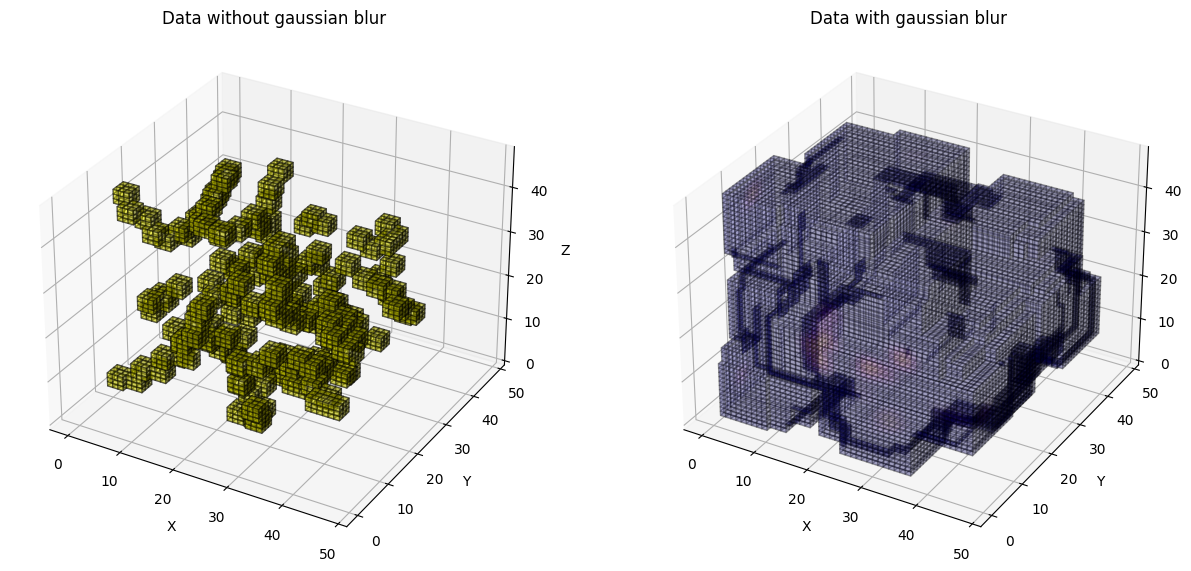

In [20]:
# We show an example data sample with and without gaussian blur
example_data_sample_gaussian_blur = vol_batch_gaus[0][1].numpy()
example_data_sample = vol_batch[0][1].numpy()

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.voxels(example_data_sample, facecolors='yellow', alpha=0.4, edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Data without gaussian blur')

colors = plt.cm.plasma(example_data_sample_gaussian_blur)
ax2.voxels(example_data_sample_gaussian_blur, facecolors=colors, alpha=0.2 ,edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Data with gaussian blur')

plt.show()

## Creating a FC layer

Here we show an example of how we would create a Quantum fully-connected layer, that we can then use in our hybrid neural network.

### Example 1

In [21]:
# One example of observables to measure (measure <Z> for all the qubits)
input_size = 4
obs = [
    "I" * i + "Z" + "I" * (input_size - i - 1)
    for i in range(input_size)
]
obs
# e.g. [
#   'ZIII',
#   'IZII',
#   'IIZI',
#   'IIIZ'
# ]
# If we leave the observables empty ("") we will measure the probability distribution instead

['ZIII', 'IZII', 'IIZI', 'IIIZ']

In [22]:
# Initializing the class
qnn = QuantumFCLayer(
    input_size=input_size, n_layers=1, encoding='qubit',
    ansatz=1, observables=obs, backend='default.qubit')

# Create the quantum layer
qnn_layer = qnn.create_layer(type_layer='torch')

x = torch.zeros((2, 4))
qnn_layer(x)

tensor([[0.1366, 0.7942, 0.3175, 0.1328],
        [0.1366, 0.7942, 0.3175, 0.1328]], grad_fn=<StackBackward0>)

### Example 2

In [23]:
# Another example with different parameters
nfeatures = 32
qnn = QuantumFCLayer(nfeatures, n_layers=2, encoding='amplitude', ansatz=2, observables="Z"*10)

qnn_layer = qnn.create_layer(type_layer='torch')

qnn_layer(rand([2, nfeatures]))

tensor([[0.3941, 0.3941, 0.3941, 0.3941, 0.3941, 0.3941, 0.3941, 0.3941, 0.3941,
         0.3941],
        [0.0894, 0.0894, 0.0894, 0.0894, 0.0894, 0.0894, 0.0894, 0.0894, 0.0894,
         0.0894]], grad_fn=<StackBackward0>)

## Create the hybrid quantum-classical neural network

Here we provide an example of how to create a hybrid neural network, using the quantum layer as a fully-connected layer.

In [24]:

class ModelHybrid(nn.Module):

    def __init__(self, feat_dim=19, n_layers=2, num_filters=[57,128,256], verbose=False, 
                encoding='qubit', ansatz=1, n_qubits=10, observables=None, backend="default.qubit"):
        super(ModelHybrid, self).__init__()

        # By default we measure all qubits
        observables = observables or [
            "I" * i + "Z" + "I" * (n_qubits - i - 1)
            for i in range(n_qubits)
        ]
        
        self.feat_dim = feat_dim
        self.num_filters = num_filters
        self.verbose = verbose

        self.conv1 = nn.Conv3d(feat_dim, num_filters[0], 7, 2, 3)
        self.bn1 = nn.BatchNorm3d(num_filters[0])
        
        self.conv2 = nn.Conv3d(num_filters[0], self.num_filters[1], 7, 3, 3)
        self.bn2 = nn.BatchNorm3d(self.num_filters[1])
        self.max_pool1 = nn.MaxPool3d(2)

        self.conv3 = nn.Conv3d(self.num_filters[1], self.num_filters[2], 5, 2, 2)
        self.bn3 = nn.BatchNorm3d(self.num_filters[2])
        self.max_pool2 = nn.MaxPool3d(2)

        self.fc1 = nn.Linear(2048, n_qubits)
        self.relu = nn.ReLU()
        
        ##################################################################################################
        # Quantum part
        self.qnn_inst = QuantumFCLayer(n_qubits, n_layers, encoding, ansatz, observables, backend)
        self.qnn = self.qnn_inst.create_layer(type_layer='torch')
        ##################################################################################################
        
        # Final layer must match number of observables
        n_obs = len(observables) if isinstance(observables, str) else len(observables[0])

        self.fc2 = nn.Linear(n_obs, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(-1)
        if self.verbose:
            print('Input', list(x.size()))
        
        conv1 = self.conv1(x)
        if self.verbose:
            print('Conv1 (7x7x7)', list(conv1.shape))

        conv2 = self.conv2(conv1)
        conv2 = self.bn2(self.relu(conv2))
        if self.verbose:
            print('Conv2 (7x7x7)', list(conv2.shape))
        
        pool1 = self.max_pool1(conv2)
        if self.verbose:
            print('Pooling 1', list(pool1.shape))
            
        conv3 = self.conv3(conv2)
        conv3 = self.bn3(self.relu(conv3))
        if self.verbose:
            print('Conv 3 (7x7x7)',list(conv3.shape))

        pool2 = self.max_pool2(conv3)
        if self.verbose:
            print('Pooling 2', list(pool2.shape))

        flattened = flatten(pool2, start_dim=1)
        if self.verbose:
            print('Flatten', list(flattened.shape))

        fc1 = self.fc1(flattened)
        fc1 = self.relu(fc1)
        if self.verbose:
            print('Fc1', list(fc1.shape))
            
        # Quantum part
        quantum = self.qnn(fc1)
        if self.verbose:
            print('Quantum', list(quantum.shape))
            
        fc2 = self.fc2(quantum)
        if self.verbose:
            print('Fc2', list(fc2.shape))
            
        return fc2
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [28]:
model1 = ModelHybrid(verbose=True, n_qubits=4)

In [29]:
print('Number of parameters hybrid CNN: ', count_parameters(model1))

Number of parameters hybrid CNN:  6979545


In [30]:
# forward training
ypred_batch1 = model1(vol_batch[:x_batch.shape[0]])

Input [5, 19, 48, 48, 48]
Conv1 (7x7x7) [5, 57, 24, 24, 24]
Conv2 (7x7x7) [5, 128, 8, 8, 8]
Pooling 1 [5, 128, 4, 4, 4]
Conv 3 (7x7x7) [5, 256, 4, 4, 4]
Pooling 2 [5, 256, 2, 2, 2]
Flatten [5, 2048]
Fc1 [5, 4]
Quantum [5, 4]
Fc2 [5, 1]


## Training steps

Here we provide an example of how to train the model. Notice that the training process is the same as if we were training a neural network with pytorch. We train the model for 1 epoch as an example. We use Adam optimizer with learning rate 0.1.

In [31]:
dataset = Dataset_MLHDF(
    'data/pdbbind2016_refined_val.hdf', 1, 'data/refined_val_3dnn.csv',
    is_crystal=True, rmsd_weight=0, rmsd_thres=100
)
val_dataset = Dataset_MLHDF(
    'data/pdbbind2016_core_test.hdf', 1, 'data/core_test_3dnn.csv',
    is_crystal=True, rmsd_weight=0, rmsd_thres=100
)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True, num_workers=0, worker_init_fn=None)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=False, num_workers=0, worker_init_fn=None)
voxelizer = Voxelizer3D(use_cuda=False, verbose=True, vol_dim=48)
gaussian_filter = GaussianFilter(dim=3, channels=19, kernel_size=11, sigma=1, use_cuda=False)

# Training params
epoch_count = 1 
start_time = time()

model1 = ModelHybrid(verbose=False, observables=obs)

# Define optimizer and loss function
optimizer1 = optim.Adam(model1.parameters(), lr=0.1)
loss_func1 = nn.MSELoss(reduction="sum")
batch_count = len(dataset) // 20

# Training loop
for epoch_ind in range(epoch_count):
    losses = []
    vol_batch = zeros((20,19,48,48,48)).float()
    for batch_ind, batch in enumerate(dataloader):
        x_batch_cpu, y_batch_cpu = batch
        x_batch, y_batch = x_batch_cpu, y_batch_cpu
        # voxelize into 3d volume
        for i in range(x_batch.shape[0]):
            xyz, feat = x_batch[i, :, :3], x_batch[i, :, 3:]
            vol_batch[i, :, :, :, :] = voxelizer(xyz, feat)
        vol_batch = gaussian_filter(vol_batch)
        
        # forward training
        ypred_batch  = model1(vol_batch[:x_batch.shape[0]])
        loss = loss_func1(ypred_batch.cpu().float(), y_batch_cpu.float())
        losses.append(loss.cpu().data.item())
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        losses.append(loss.cpu().data.item())
        time_step = time() - start_time
        print("[%d/%d-%d/%d] training, loss: %.3f, time so far: %.3f seconds" % (epoch_ind+1, epoch_count,
                  batch_ind+1, batch_count, loss.cpu().data.item(), time_step))
        
    print("[%d/%d] training, epoch loss: %.3f, time so far: %.3f seconds\n" %
              (epoch_ind+1, epoch_count, np.mean(losses), time_step))
    
    val_losses = []
    for batch_ind, batch in enumerate(val_dataloader):
        x_batch_cpu, y_batch_cpu = batch
        x_batch, y_batch = x_batch_cpu, y_batch_cpu
        # voxelize into 3d volume
        for i in range(x_batch.shape[0]):
            xyz, feat = x_batch[i, :, :3], x_batch[i, :, 3:]
            vol_batch[i, :, :, :, :] = voxelizer(xyz, feat)
        vol_batch = gaussian_filter(vol_batch)
        ypred_batch = model1(vol_batch[:x_batch.shape[0]])
        loss = loss_func1(ypred_batch.cpu().float(),
                                       y_batch_cpu.float())
        print("[%d/%d-%d/%d] validation, loss: %.3f" % (epoch_ind+1,
                          epoch_count, batch_ind+1, batch_count, loss.cpu().data.item()))
        
        val_losses.append(loss.cpu().data.item())
        
    print("[%d/%d] validation, epoch loss: %.3f\n" %
                      (epoch_ind+1, epoch_count, np.mean(val_losses)))

# close dataset
dataset.close()
val_dataset.close()

[1/1-1/19] training, loss: 0.108, time so far: 59.419 seconds
[1/1-2/19] training, loss: 0.254, time so far: 118.682 seconds
[1/1-3/19] training, loss: 0.380, time so far: 178.512 seconds
[1/1-4/19] training, loss: 0.265, time so far: 238.102 seconds
[1/1-5/19] training, loss: 0.120, time so far: 302.667 seconds
[1/1-6/19] training, loss: 0.017, time so far: 362.119 seconds
[1/1-7/19] training, loss: 0.012, time so far: 420.441 seconds
[1/1-8/19] training, loss: 0.049, time so far: 478.182 seconds
[1/1-9/19] training, loss: 0.086, time so far: 535.291 seconds
[1/1-10/19] training, loss: 0.075, time so far: 592.017 seconds
[1/1-11/19] training, loss: 0.043, time so far: 651.717 seconds
[1/1-12/19] training, loss: 0.009, time so far: 717.107 seconds
[1/1-13/19] training, loss: 0.002, time so far: 780.394 seconds
[1/1-14/19] training, loss: 0.019, time so far: 838.620 seconds
[1/1-15/19] training, loss: 0.039, time so far: 896.361 seconds
[1/1-16/19] training, loss: 0.044, time so far: 95

### Code to save the model

In [50]:
# Save the model
save(model1.state_dict(), "saved_models/model3DCNN_FC.pt")

### Code to load the model

In [51]:
# Load a model
loaded_model = ModelHybrid(verbose=False, observables=obs)
loaded_model.load_state_dict(load("saved_models/model3DCNN_FC.pt"))

<All keys matched successfully>

## Available architectures for the Quantum Fully-connected layer

Here we describe the different implemented architectures for the quantum fully-connected layer, that the user can explore and play with. Such quantum layer contains two parts: a data encoding layer and a parametrized quantum circuit. 

## Data encoding

It is the process of encoding classical data into a quantum circuit. We propose different alternatives.

### 1. Qubit encoding

This is the default encoding. This encoding uses one qubit for each classical number that we want to encode. However, it ony uses one quantum gate for each qubit.

$$
|\phi(x)> = \otimes_{i=1}^N (\cos(\frac{x_i}{2} |0> + \sin(\frac{x_i}{2} |1>)
$$


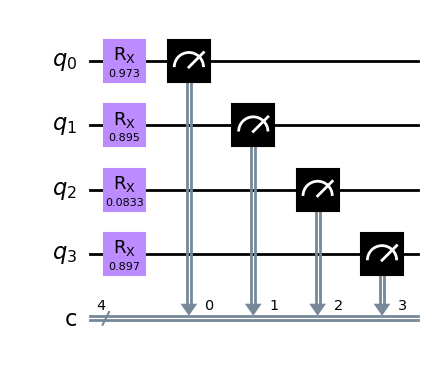

In [12]:
nqbits = 4
dev = qml.device('qiskit.aer', wires=nqbits)
@qml.qnode(dev)
def qubit_encoding(feature_vector):
    qml.AngleEmbedding(features=feature_vector, wires=range(nqbits), rotation='X')
    return qml.probs(wires = list(range(nqbits)))

feature_vector = np.random.random(nqbits)
qubit_encoding(feature_vector)  # We make a forward pass to initialize the weights
dev._circuit.draw('mpl')

### 2. Amplitude encoding

This encoding uses a $log_2(\text{features})$ qubits to encode the data, but it requires many more quantum gates.

$$
|\phi(x)> = \frac{1}{|x|} \sum_{i=1}^N x_i |i>
$$


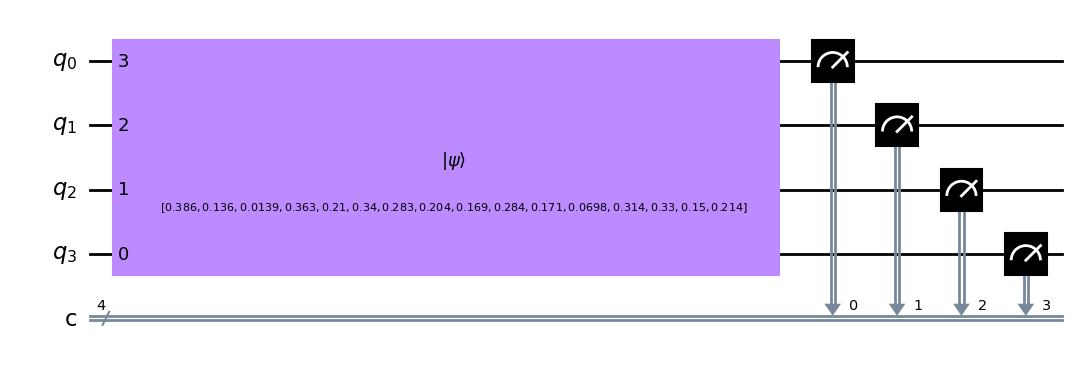

In [38]:
nqbits = 4
dev = qml.device('qiskit.aer', wires=nqbits)
@qml.qnode(dev)
def amplitude_encoding(feature_vector):
        qml.AmplitudeEmbedding(features=feature_vector, wires=range(nqbits),normalize=True)
        return qml.probs(wires = list(range(nqbits)))

feature_vector = np.random.random(2**nqbits)
amplitude_encoding(feature_vector)  # We make a forward pass to initialize the weights
dev._circuit.draw('mpl')

### 3. ZZFeatureMap

Second-order Pauli-Z evolution circuit.

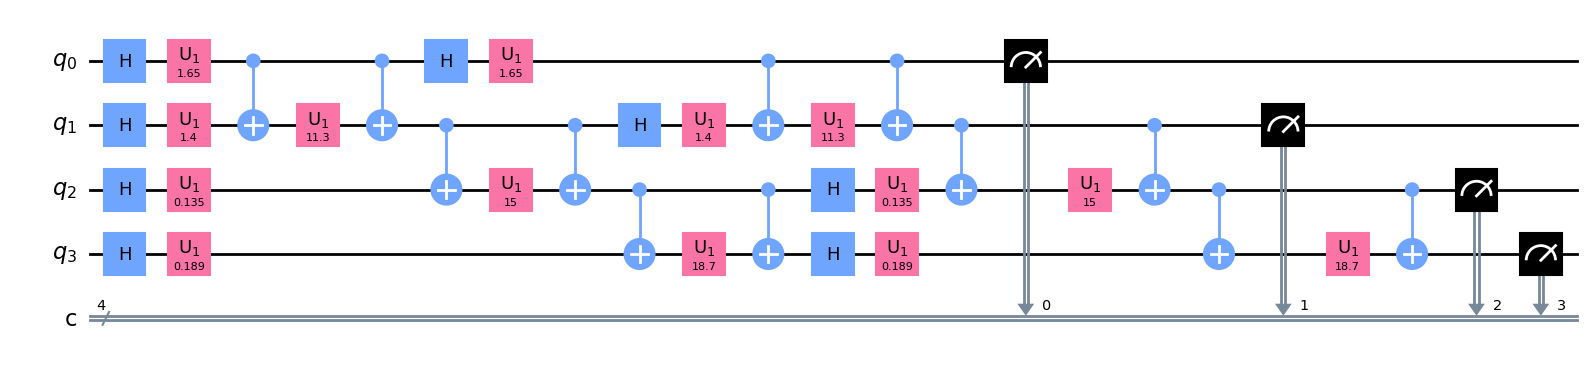

In [16]:
nqbits = 4
dev = qml.device('qiskit.aer', wires=nqbits)
@qml.qnode(dev)
def ZZFeatureMap_encoding(feature_vector, n_layers=2):
    for _ in range(n_layers):
        for i in range(nqbits):
            qml.Hadamard(wires = i)
            qml.U1(2*feature_vector[i], wires =i)
        # CNOT + hadamard
        for i in range(1,nqbits):
            if i-2>=0:
                qml.CNOT(wires=[i-2, i-1])
            qml.CNOT(wires=[i-1, i])
            qml.U1(2*(np.pi - feature_vector[i-1])*(np.pi - feature_vector[i]), wires = i)
        qml.CNOT(wires=[nqbits - 2, nqbits-1])
    return qml.probs(wires = list(range(nqbits)))

feature_vector = np.random.random(nqbits)
ZZFeatureMap_encoding(feature_vector)  # We make a forward pass to initialize the weights
dev._circuit.draw('mpl')

### 4. QAOA encoding

Encodes $N$ features into $n>N$ qubits, using a layered, trainable quantum circuit that is inspired by the QAOA ansatz.

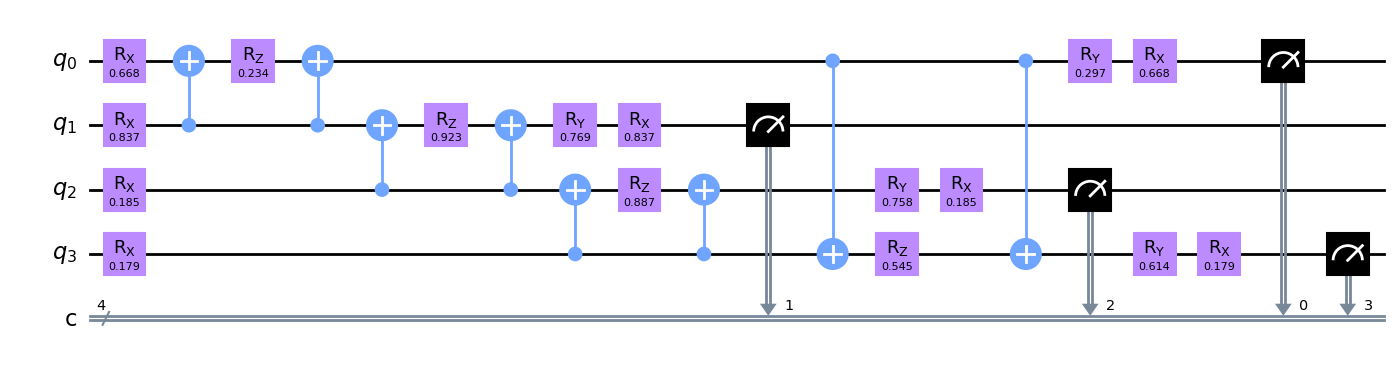

In [17]:
nqbits = 4
dev = qml.device('qiskit.aer', wires=nqbits)
@qml.qnode(dev)
def QAOA_encoding(feature_vector, input_weights):
        qml.QAOAEmbedding(features=feature_vector, weights=input_weights, wires=range(len(feature_vector)))
        return qml.probs(wires = list(range(nqbits)))

feature_vector = np.random.random(nqbits)
input_weights = np.random.random((1, 2*nqbits))
QAOA_encoding(feature_vector, input_weights)  # We make a forward pass to initialize the weights
dev._circuit.draw('mpl')

## Ansatz

The second part of the circuit is a paramterized quantum circuit (PQC). The choice of this quantum circuit (ansatz) determines the performance of the model. In Ref. [1], the authors explore different choces of PQC and measure two quantum properties: the Expressability and the Entanglement capacity.

+ Expressibility measures a PQC’s ability to explore the Hilbert Space, that is, to produce different quantum states. To measure it, one calculates the probability distribution of the fidelity of two random states from the circuit. This distribution is then compared with the random distribution (Haar random states). The KL divergence of the two distributions is the Expressibility of the circuit. The value of Expressibility is less for more expressive circuits.

+ Entanglement Capability is a numerical method that quantifies a PQCs ability to produce entangled states. It averages the Meyer-Wallach entanglement measure (Q) over many random samples obtained from the PQC.

Expressibility and Entanglement Capability are descriptors that allow comparison of layered PQCs. For this reason, we provide circuits with different values of Expressibility and Entangling capacity. We provide six PQC, ordered in terms of performance and lower complexity based on Refs. [2],[3],[1]. 

[1] Sim, S., Johnson, P.D. and Aspuru-Guzik, A. (2019), Expressibility and Entangling Capability of Parameterized Quantum Circuits for Hybrid Quantum-Classical Algorithms. Adv. Quantum Technol., 2: 1900070. https://doi.org/10.1002/qute.201900070

[2] Tüysüz, C., Rieger, C., Novotny, K. et al. Hybrid quantum classical graph neural networks for particle track reconstruction. Quantum Mach. Intell. 3, 29 (2021). https://doi.org/10.1007/s42484-021-00055-9

[3] Hur, Tak & Kim, Leeseok & Park, Daniel. (2021). Quantum convolutional neural network for classical data classification. https://doi.org/10.1103/PhysRevResearch.4.013231


### 1. Circuit 10 

This circuit has low expressability. It provided the best performance for the NN in Ref. [2]. It's option 1 for the Quantum Layer.

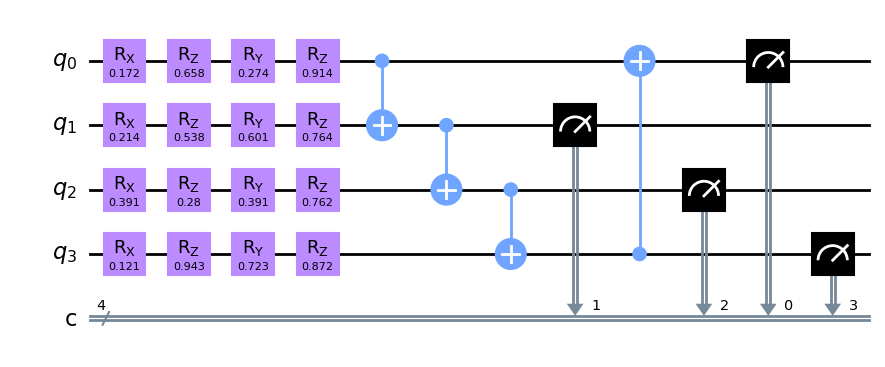

In [112]:
input_size=4
qnn = QuantumFCLayer(
    input_size=input_size, n_layers=1, encoding='qubit',
    ansatz=1, observables="", backend='default.qubit')

qnn.create_layer()
# To properly draw the circuit we need to initialize the weights first
weights = np.random.random(qnn.weights_shape)
inputs =  np.random.random((2,input_size))
dev = qml.device("qiskit.aer", wires=input_size) # We use qiskit aer for better visualization
qnode = qml.QNode(qnn.qnn_layer, dev) # We create the qnode
qnode(inputs, weights)  # We make a forward pass to initialize the weights
dev._circuit.draw('mpl') # We draw the resulting circuit

### Circuit 9
This circuit has the best Entangling capacity from the study in Ref. [1]. It's option 2 for the Quantum Layer.

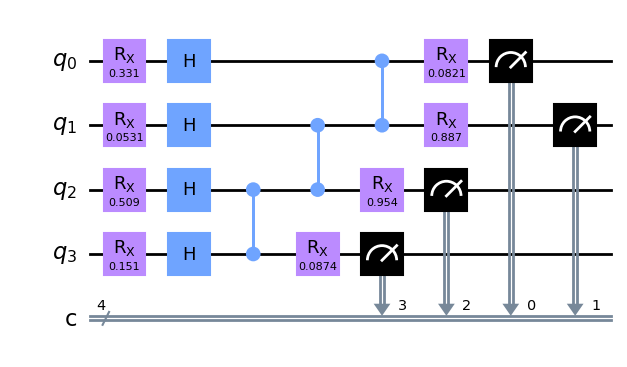

In [113]:
input_size=4
qnn = QuantumFCLayer(
    input_size=input_size, n_layers=1, encoding='qubit',
    ansatz=2, observables="", backend='default.qubit')

qnn.create_layer()
# To properly draw the circuit we need to initialize the weights first
weights = np.random.random(qnn.weights_shape)
inputs =  np.random.random((2,input_size))
dev = qml.device("qiskit.aer", wires=input_size) # We use qiskit aer for better visualization
qnode = qml.QNode(qnn.qnn_layer, dev) # We create the qnode
qnode(inputs, weights)  # We make a forward pass to initialize the weights
dev._circuit.draw('mpl') # We draw the resulting circuit

### Circuit 15

This circuit has high entangling capacity and low expressability. It has lower complexiyt than circuits 14 and 13. It's option 3 for the Quantum Layer.

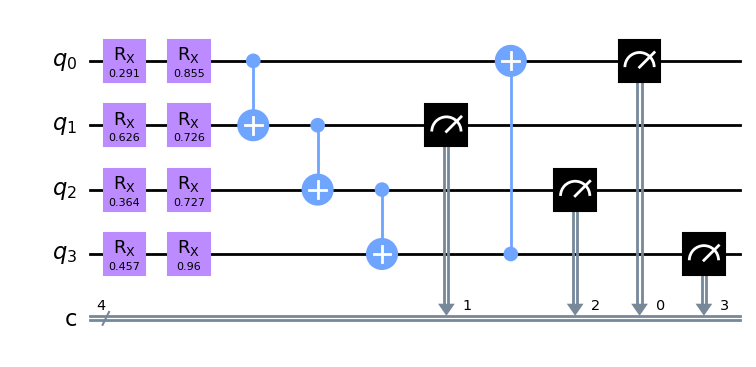

In [116]:
input_size=4
qnn = QuantumFCLayer(
    input_size=input_size, n_layers=1, encoding='qubit',
    ansatz=3, observables="", backend='default.qubit')

qnn.create_layer()
# To properly draw the circuit we need to initialize the weights first
weights = np.random.random(qnn.weights_shape)
inputs =  np.random.random((2,input_size))
dev = qml.device("qiskit.aer", wires=input_size) # We use qiskit aer for better visualization
qnode = qml.QNode(qnn.qnn_layer, dev) # We create the qnode
qnode(inputs, weights)  # We make a forward pass to initialize the weights
dev._circuit.draw('mpl') # We draw the resulting circuit

### Circuit 14

This circuit balanced significance in entangling capacity and expressability. It has higher complexiy than circuit 15. It's option 4 for the Quantum Layer.

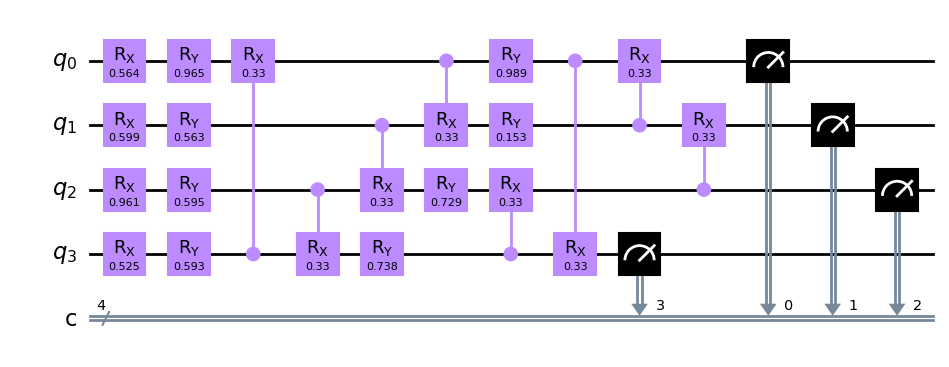

In [117]:
input_size=4
qnn = QuantumFCLayer(
    input_size=input_size, n_layers=1, encoding='qubit',
    ansatz=4, observables="", backend='default.qubit')

qnn.create_layer()
# To properly draw the circuit we need to initialize the weights first
weights = np.random.random(qnn.weights_shape)
inputs =  np.random.random((2,input_size))
dev = qml.device("qiskit.aer", wires=input_size) # We use qiskit aer for better visualization
qnode = qml.QNode(qnn.qnn_layer, dev) # We create the qnode
qnode(inputs, weights)  # We make a forward pass to initialize the weights
dev._circuit.draw('mpl') # We draw the resulting circuit

### Circuit 13

This circuit balanced significance in entangling capacity and expressability. It has higher complexiy than circuit 15. It's option 5 for the Quantum Layer.

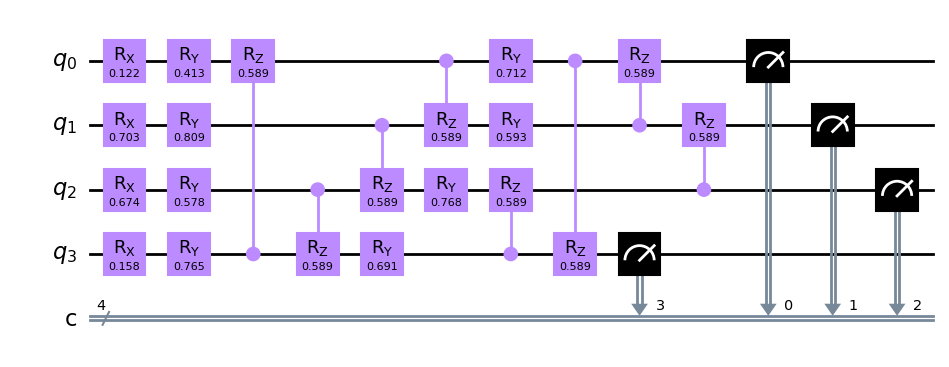

In [118]:
input_size=4
qnn = QuantumFCLayer(
    input_size=input_size, n_layers=1, encoding='qubit',
    ansatz=5, observables="", backend='default.qubit')

qnn.create_layer()
# To properly draw the circuit we need to initialize the weights first
weights = np.random.random(qnn.weights_shape)
inputs =  np.random.random((2,input_size))
dev = qml.device("qiskit.aer", wires=input_size) # We use qiskit aer for better visualization
qnode = qml.QNode(qnn.qnn_layer, dev) # We create the qnode
qnode(inputs, weights)  # We make a forward pass to initialize the weights
dev._circuit.draw('mpl') # We draw the resulting circuit

### 2. Circuit 6

This circuit has the highest expressability, but very high complexity. It's option 6 for the Quantum Layer.

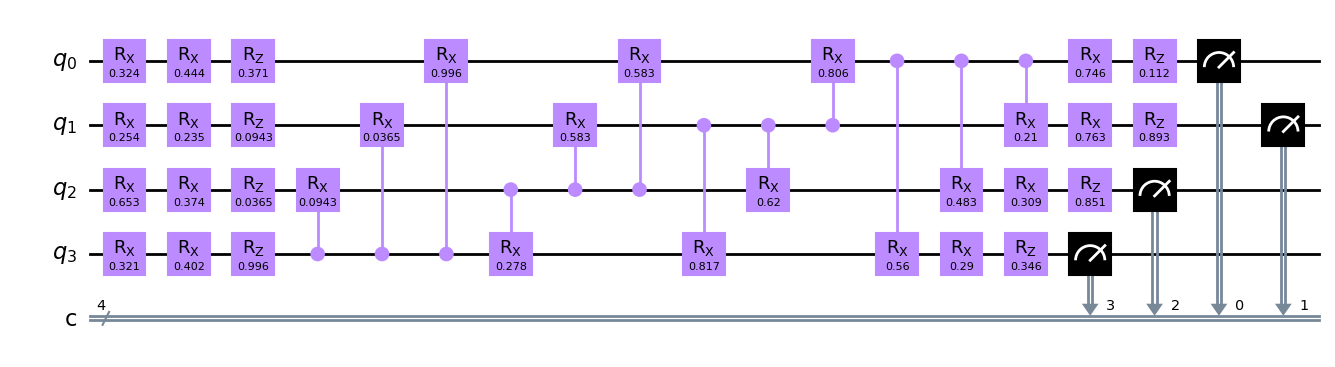

In [119]:
input_size=4
qnn = QuantumFCLayer(
    input_size=input_size, n_layers=1, encoding='qubit',
    ansatz=6, observables="", backend='default.qubit')

qnn.create_layer()
# To properly draw the circuit we need to initialize the weights first
weights = np.random.random(qnn.weights_shape)
inputs =  np.random.random((2,input_size))
dev = qml.device("qiskit.aer", wires=input_size) # We use qiskit aer for better visualization
qnode = qml.QNode(qnn.qnn_layer, dev) # We create the qnode
qnode(inputs, weights)  # We make a forward pass to initialize the weights
dev._circuit.draw('mpl') # We draw the resulting circuit